# IIA 2024 - Aprendizaje Automatizado
### Lucas Poma
## Trabajo Practico 4

## Definiciones

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

### Redes Neuronales

In [2]:
N2 = 6
learning_rate = 0.02
momentum = 0.85
gamma = 0.00001
epochs = 20
evals = 200

In [3]:
from sklearn.neural_network import MLPClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
def MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma):
    return MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate,momentum=momentum,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epochs)

In [5]:
def error_clasificacion(y, y_pred):
    return sk.metrics.zero_one_loss(y, y_pred)

def entrenar_red_peso(red, evaluaciones, X_train, y_train, X_test, y_test):
    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
        red.fit(X_train, y_train)
        weights = red.coefs_
        weight_sum.append(sum(np.sum(np.square(w)) for w in weights))
        error_train.append(error_clasificacion(y_train, red.predict(X_train)))
        error_test.append(error_clasificacion(y_test, red.predict(X_test)))

    return red, error_train, error_test, weight_sum

### Bayes

In [6]:
from sklearn.naive_bayes import GaussianNB

### Arboles

In [7]:
from sklearn.tree import DecisionTreeClassifier

### Paralelas

In [8]:
def paralelas(n, d, C):
  half = int(n/2)

  mClass0 = np.zeros(d)
  mClass0[0] = 1
  mClass1 = np.zeros(d)
  mClass1[0] = -1
  covM = np.identity(d) * (C**2)

  class0 = np.random.multivariate_normal(mClass0, covM, half)
  class1 = np.random.multivariate_normal(mClass1, covM, n - half)

  labels0 = np.zeros((half, 1))
  labels1 = np.ones((n - half, 1))

  data0 = np.hstack((class0, labels0))
  data1 = np.hstack((class1, labels1))

  data = np.vstack((data0, data1))

  columns = [f'dim_{i}' for i in range(d)] + ['class']
  dataFrame = pd.DataFrame(data, columns=columns)

  return dataFrame

### Diagonales

In [9]:
def diagonales(n, d, C):
  half = int(n/2)

  mClass0 = -np.ones(d)
  mClass1 = np.ones(d)
  covM = np.identity(d) * (C**2 * d)

  class0 = np.random.multivariate_normal(mClass0, covM, half)
  class1 = np.random.multivariate_normal(mClass1, covM, n - half)

  labels0 = np.zeros((half, 1))
  labels1 = np.ones((n - half, 1))

  data0 = np.hstack((class0, labels0))
  data1 = np.hstack((class1, labels1))

  data = np.vstack((data0, data1))

  columns = [f'dim_{i}' for i in range(d)] + ['class']
  dataFrame = pd.DataFrame(data, columns=columns)

  return dataFrame

### Espirales

In [10]:
def inside_circle(x,y):
  return np.linalg.norm([x,y]) <= 1

def cartesian_to_polar(x, y):
    rho = (x**2 + y**2)**0.5
    theta = math.atan2(y, x)
    return rho, theta

def in_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*math.pi) / (4 * math.pi)
  rho_curve2 = (theta + npi*math.pi) / (4 * math.pi)
  return rho_curve1 <= rho <= rho_curve2

def in_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    for i in [1, 3, 5, 7]:
        if in_curve(rho, theta, i):
            return True
    return False

def espirales(n):
  half = int(n/2)
  bothClass = []
  countClass0 = 0
  countClass1 = 0

  while (countClass0 < half or countClass1 < n-half):
    gen = np.random.uniform(-1,1,size=(half,2))
    for (x,y) in gen:
      if (inside_circle(x,y)):
        if (in_curves(x,y)):
          if (countClass0 < half):
            bothClass.append([x,y,0])
            countClass0 += 1
        else:
          if (countClass1 < n - half):
            bothClass.append([x,y,1])
            countClass1 += 1
  df = pd.DataFrame(bothClass, columns=['dim_0', 'dim_1', 'class'])
  return df

## Entrenamiento KNN

In [11]:
CLASSIFIER = 0
REGRESSOR = 1

def entrenar_knn(tipo, vecinos, X_train, y_train, X_val, y_val, X_test, y_test, weights='uniform'):
    error_val = []
    error_train = []
    error_test = []
    min_error_val = float('inf')

    funcion_error = error_clasificacion if tipo == CLASSIFIER else error_regresion

    for i in range(1, vecinos + 1):
        knn = KNeighborsClassifier(n_neighbors=i, weights=weights) if tipo == CLASSIFIER else KNeighborsRegressor(n_neighbors=i, weights=weights)

        knn.fit(X_train, y_train)
        aux_err_val = funcion_error(y_val, knn.predict(X_val))

        if aux_err_val < min_error_val:
            min_error_val = aux_err_val
            best_knn = copy.deepcopy(knn)

        error_val.append(aux_err_val)
        error_train.append(funcion_error(y_train, knn.predict(X_train)))
        error_test.append(funcion_error(y_test, knn.predict(X_test)))

    return best_knn, error_train, error_val, error_test

def error_regresion(y, y_pred):
    return sk.metrics.mean_squared_error(y, y_pred)

def error_clasificacion(y, y_pred):
    return sk.metrics.zero_one_loss(y, y_pred)

def entrenar_knn_regresion(vecinos, X_train, y_train, X_val, y_val, X_test, y_test):
    return entrenar_knn(REGRESSOR, vecinos, X_train, y_train, X_val, y_val, X_test, y_test)

def entrenar_knn_clasificacion(vecinos, X_train, y_train, X_val, y_val, X_test, y_test):
    return entrenar_knn(CLASSIFIER, vecinos, X_train, y_train, X_val, y_val, X_test, y_test)

entrenar_knn_clasificacion_peso = entrenar_knn_clasificacion(weights='distance')
entrenar_knn_regresion_peso = entrenar_knn_regresion(weights='distance')

In [12]:
def plot_errors_knn(ax, error_train, error_val, error_test, vecinos, title):
    rango = range(1, vecinos + 1)
    ax.set_title(title)
    ax.plot(rango, error_train, label='Error de Entrenamiento', color='red', linestyle="-")
    ax.plot(rango, error_val, label='Error de Validacion', color='blue', linestyle="-")
    ax.plot(rango, error_test, label='Error de Test', color='green', linestyle="-")
    ax.legend()

## Ejercicio 1

In [17]:
MAX_VECINOS = 50

### Espirales Normales

In [21]:
csv = pd.read_csv('DataSets/c_0.data', names=['dim_0', 'dim_1', 'class'])
X = csv.drop(columns=['class'])
y = csv['class']

csv = pd.read_csv('DataSets/c_0.test', names=['dim_0', 'dim_1', 'class'])
X_test = csv.drop(columns=['class'])
y_test = csv['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [24]:
bestknn, error_train, error_val, error_test = entrenar_knn_clasificacion(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)

tree = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, min_samples_leaf=5)
tree = tree.fit(X, y)

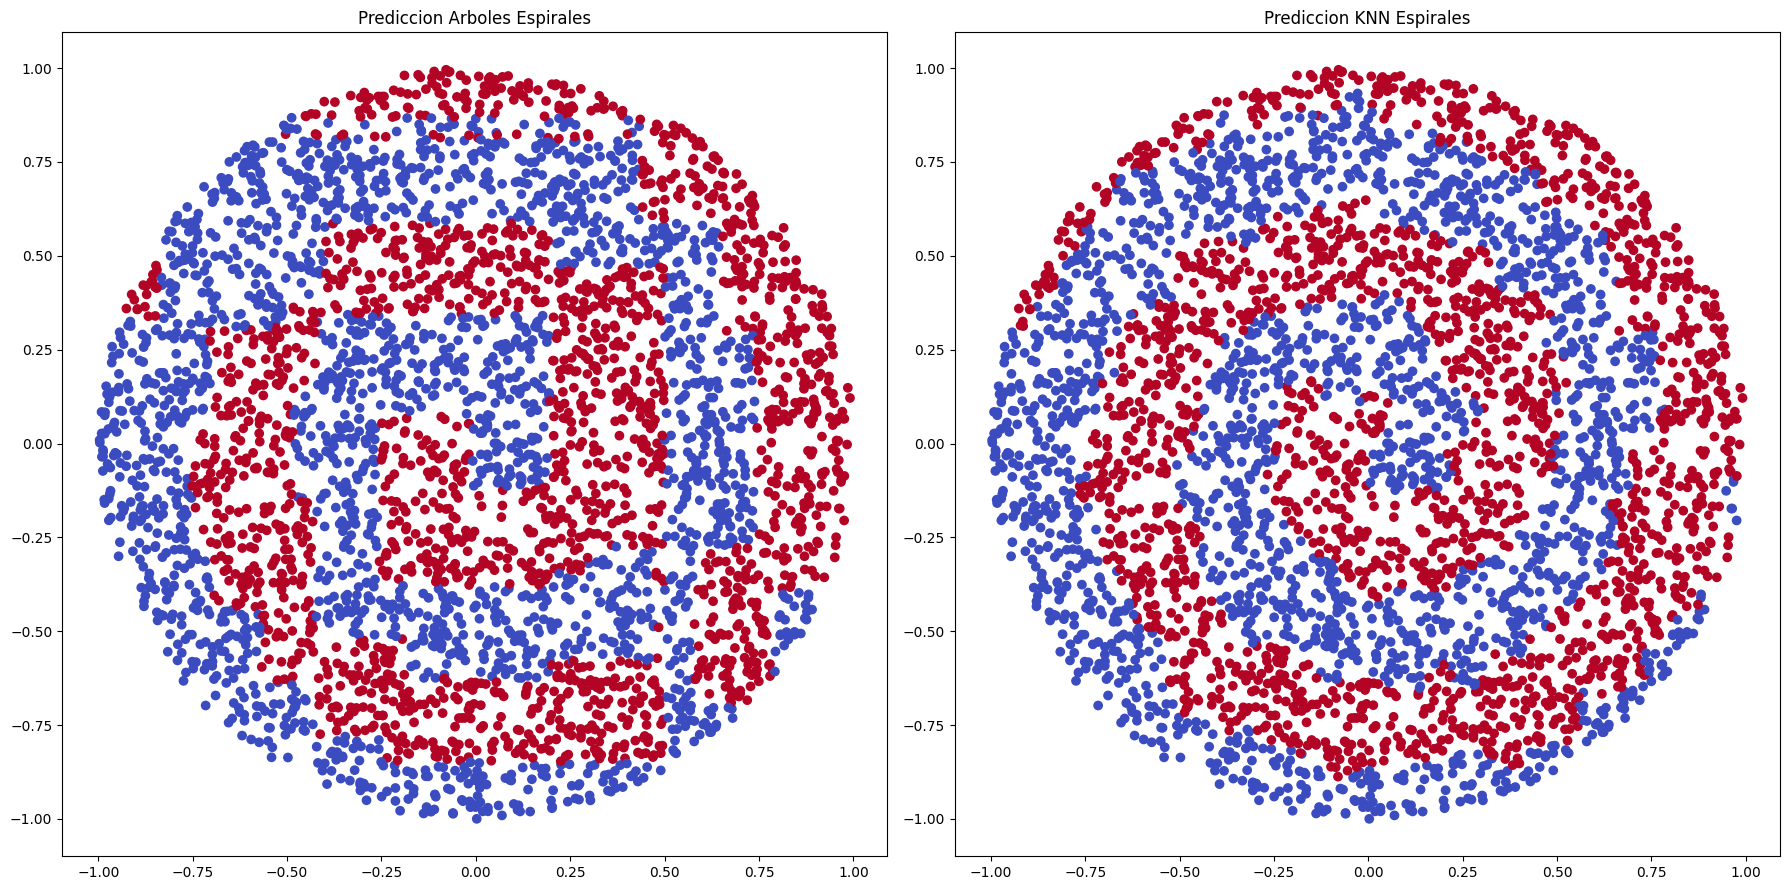

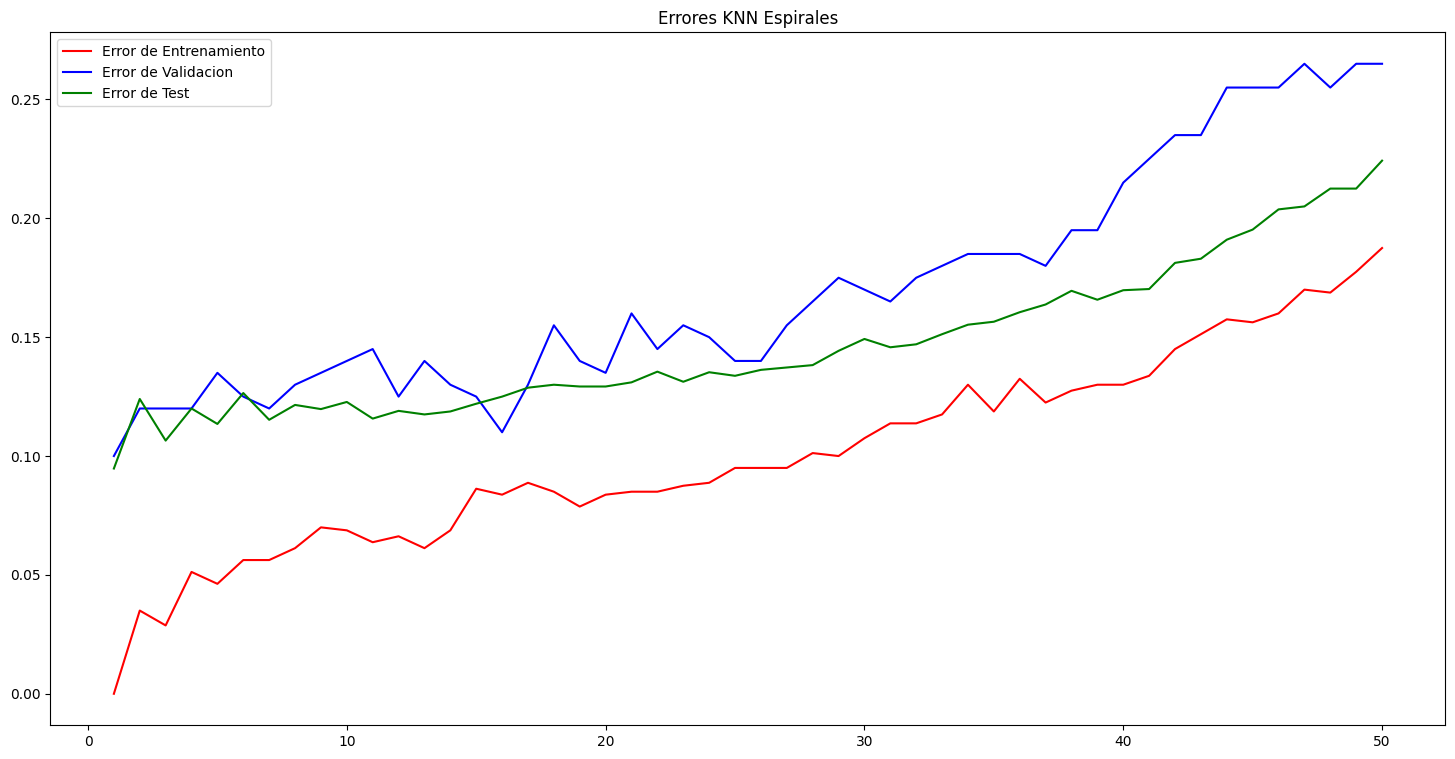

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=tree.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion Arboles Espirales')

ax = axs[1]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=bestknn.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion KNN Espirales')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(18, 9))
ax = axs
plot_errors_knn(ax, error_train, error_val, error_test, MAX_VECINOS, 'Errores KNN Espirales')
plt.show()

In [26]:
csv = pd.read_csv('DataSets/c_2.data', names=['dim_0', 'dim_1', 'dim_2', 'dim_3', 'class'])
X = csv.drop(columns=['class'])
y = csv['class']

csv = pd.read_csv('DataSets/c_2.test', names=['dim_0', 'dim_1', 'dim_2', 'dim_3', 'class'])
X_test = csv.drop(columns=['class'])
y_test = csv['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [27]:
bestknn, error_train, error_val, error_test = entrenar_knn_clasificacion(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)

tree = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, min_samples_leaf=5)
tree = tree.fit(X, y)

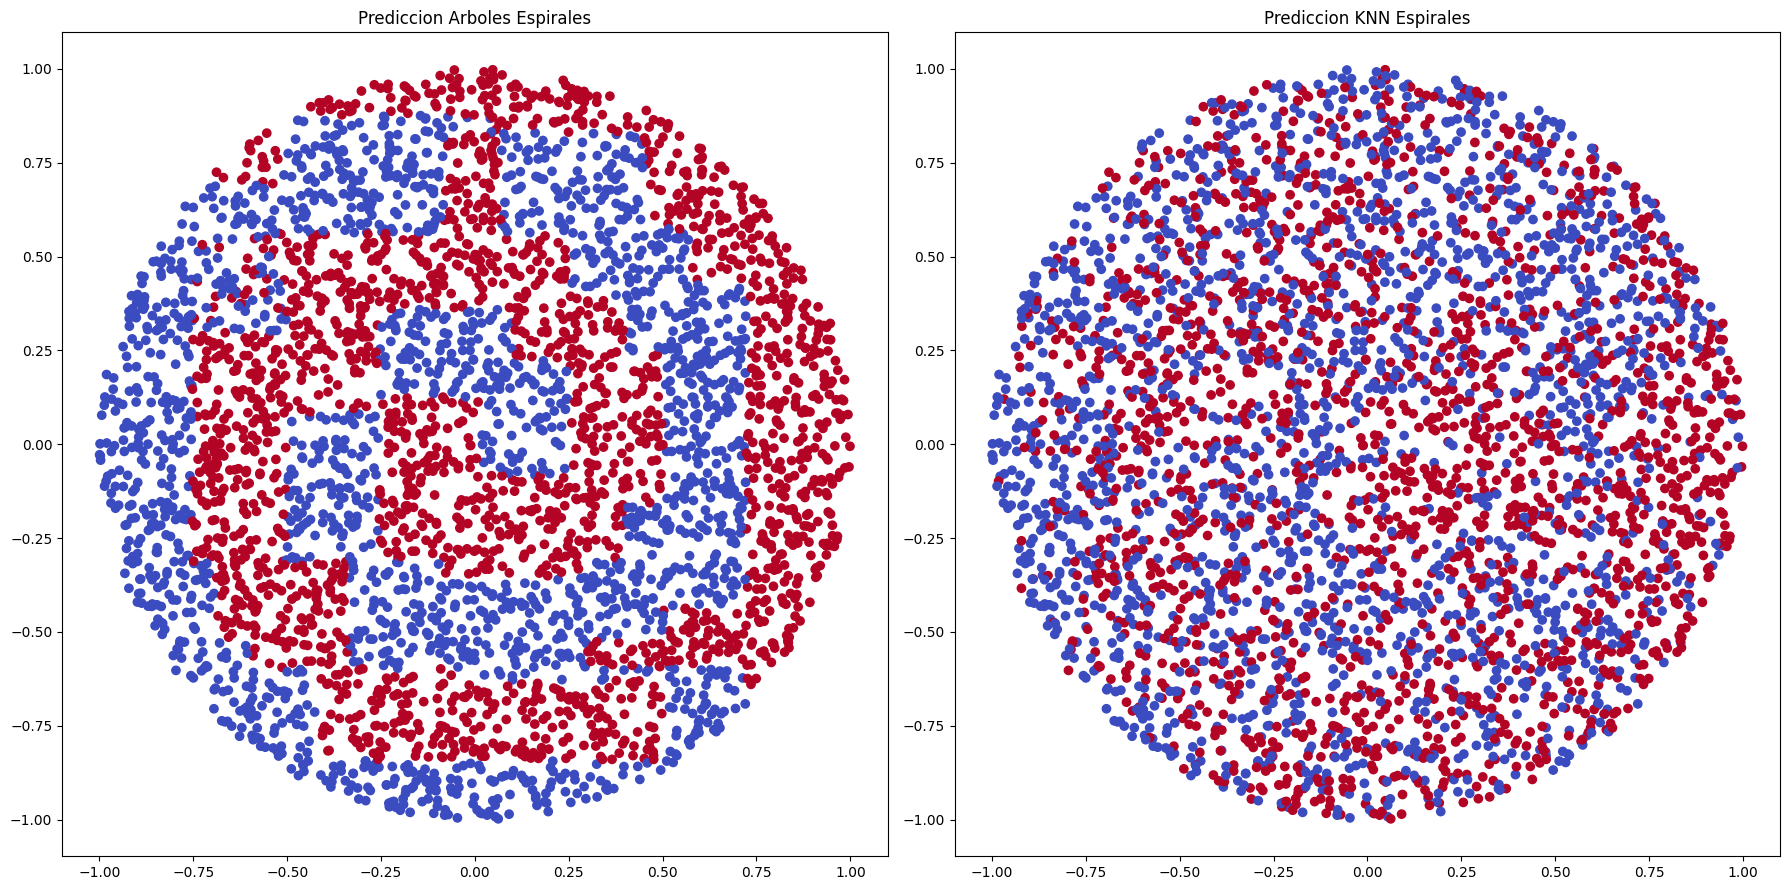

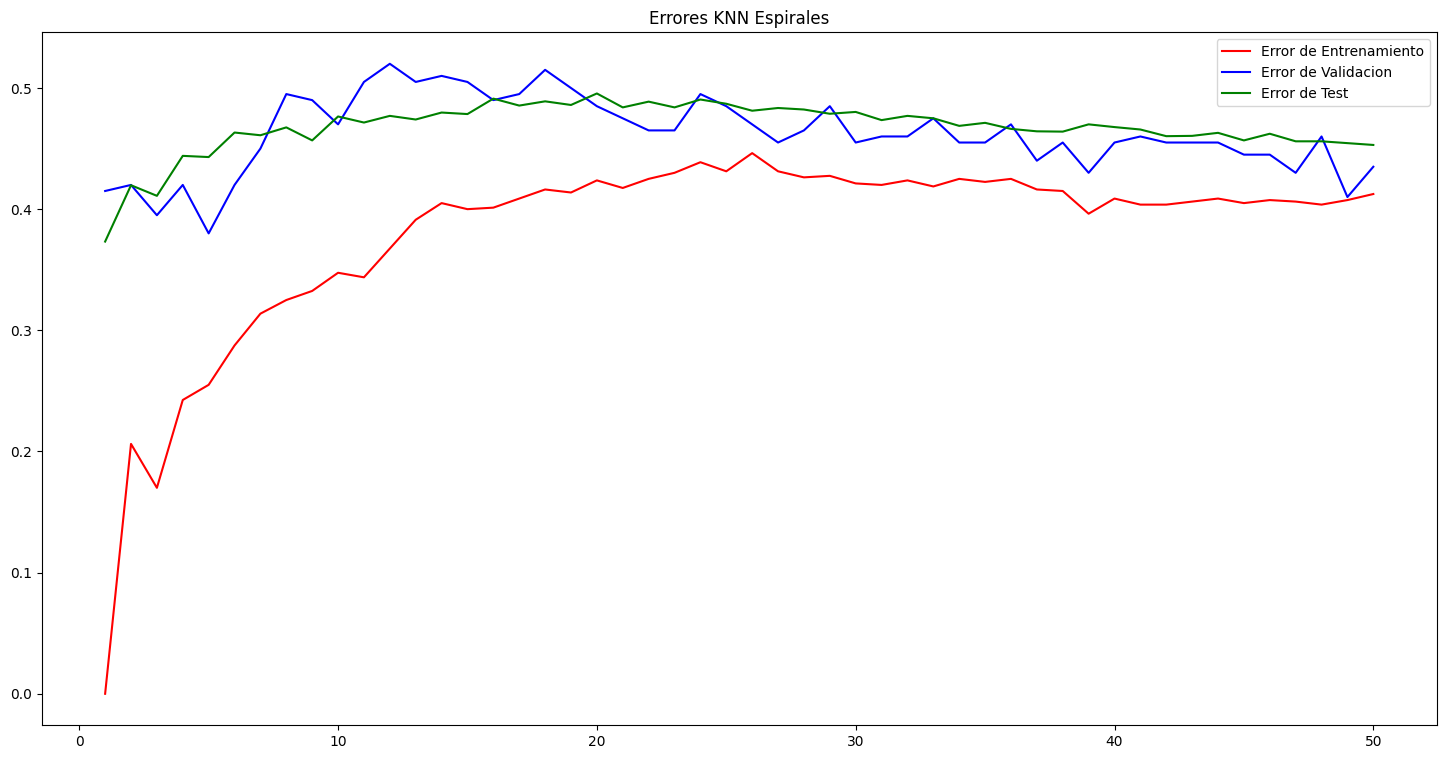

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
ax = axs[0]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=tree.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion Arboles Espirales')

ax = axs[1]
ax.scatter(X_test['dim_0'], X_test['dim_1'], c=bestknn.predict(X_test), cmap='coolwarm')
ax.set_title(f'Prediccion KNN Espirales')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(18, 9))
ax = axs
plot_errors_knn(ax, error_train, error_val, error_test, MAX_VECINOS, 'Errores KNN Espirales')
plt.show()

## Ejercicio 2

### Setup

In [33]:
dimensiones = [2, 4, 8, 16, 32]
overlap = 0.78
testSamples = 10000
MAX_VECINOS = 50
dataParalelasTree = []
dataDiagonalesTree = []
dataParalelasRed = []
dataDiagonalesRed = []
dataParalelasBayes = []
dataDiagonalesBayes = []
dataParalelasKNN = []
dataDiagonalesKNN = []
dataParalelas1NN = []
dataDiagonales1NN = []

### Diagonales

In [34]:
for dimension in dimensiones:
    testDiagonales10000 = diagonales(testSamples, dimension, overlap)
    X_test = testDiagonales10000.drop(columns=['class'])
    y_test = testDiagonales10000['class']

    for conjunto in range(0,2):
        dfDiagonales = diagonales(250, dimension, overlap)
        X = dfDiagonales.drop(columns=['class'])
        y = dfDiagonales['class']

        clf = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, random_state=0, min_samples_leaf=5)
        clf = clf.fit(X, y)
        errTest = 1 - clf.score(X_test, y_test)
        errEntrenamiento = 1 - clf.score(X, y)
        dataDiagonalesTree.append([dimension, conjunto, errTest, errEntrenamiento])

        clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
        best_red, _, _, _ = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)
        errTest = error_clasificacion(y_test, best_red.predict(X_test))
        errEntrenamiento = error_clasificacion(y, best_red.predict(X))
        dataDiagonalesRed.append([dimension, conjunto, errTest, errEntrenamiento])

        clfb = GaussianNB()
        clfb.fit(X, y)
        errTest = 1 - clfb.score(X_test, y_test)
        errEntrenamiento = 1 - clfb.score(X, y)
        dataDiagonalesBayes.append([dimension, conjunto, errTest, errEntrenamiento])

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        best_knn, _, _, _ = entrenar_knn_clasificacion(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)
        errTest = error_clasificacion(y_test, best_knn.predict(X_test))
        errEntrenamiento = error_clasificacion(y_train, best_knn.predict(X_train))
        dataParalelasKNN.append([dimension, conjunto, errTest, errEntrenamiento])

        best_knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')
        best_knn.fit(X, y)
        errTest = error_clasificacion(y_test, best_knn.predict(X_test))
        errEntrenamiento = error_clasificacion(y, best_knn.predict(X))
        dataParalelas1NN.append([dimension, conjunto, errTest, errEntrenamiento])

### Paralelas

In [35]:
for dimension in dimensiones:
    testParalelas10000 = paralelas(testSamples, dimension, overlap)
    X_test = testParalelas10000.drop(columns=['class'])
    y_test = testParalelas10000['class']

    for conjunto in range(0,2):
        dfParalelas = paralelas(250, dimension, overlap)
        X = dfParalelas.drop(columns=['class'])
        y = dfParalelas['class']
        clf = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, random_state=0, min_samples_leaf=5)
        clf = clf.fit(X, y)
        errTest = 1 - clf.score(X_test, y_test)
        errEntrenamiento = 1 - clf.score(X, y)
        dataParalelasTree.append([dimension, conjunto, errTest, errEntrenamiento])

        clasif = MLPClassifPeso(N2, momentum, learning_rate, epochs, gamma)
        best_red, _, _, _ = entrenar_red_peso(clasif, evals, X, y, X_test, y_test)
        errTest = error_clasificacion(y_test, best_red.predict(X_test))
        errEntrenamiento = error_clasificacion(y, best_red.predict(X))
        dataParalelasRed.append([dimension, conjunto, errTest, errEntrenamiento])

        clfb = GaussianNB()
        clfb.fit(X, y)
        errTest = 1 - clfb.score(X_test, y_test)
        errEntrenamiento = 1 - clfb.score(X, y)
        dataParalelasBayes.append([dimension, conjunto, errTest, errEntrenamiento])

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        best_knn, _, _, _ = entrenar_knn_clasificacion(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)
        errTest = error_clasificacion(y_test, best_knn.predict(X_test))
        errEntrenamiento = error_clasificacion(y_train, best_knn.predict(X_train))
        dataParalelasKNN.append([dimension, conjunto, errTest, errEntrenamiento])

        best_knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')
        best_knn.fit(X, y)
        errTest = error_clasificacion(y_test, best_knn.predict(X_test))
        errEntrenamiento = error_clasificacion(y, best_knn.predict(X))
        dataParalelas1NN.append([dimension, conjunto, errTest, errEntrenamiento])

### Resultados

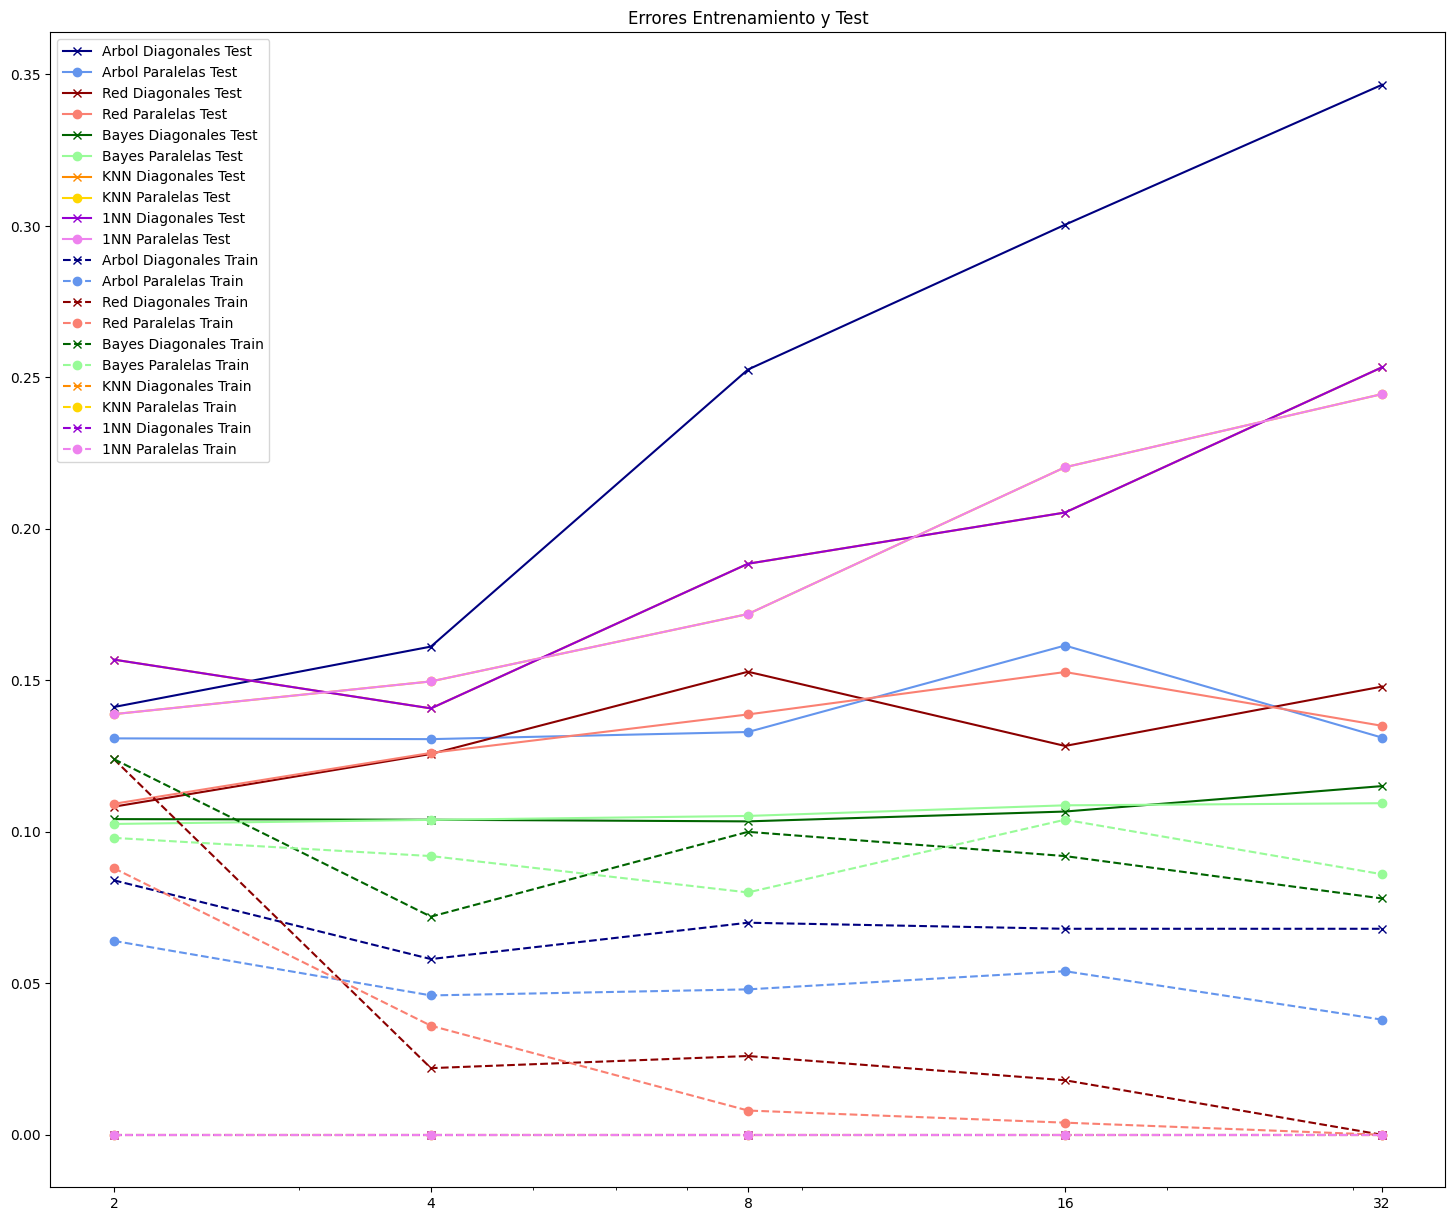

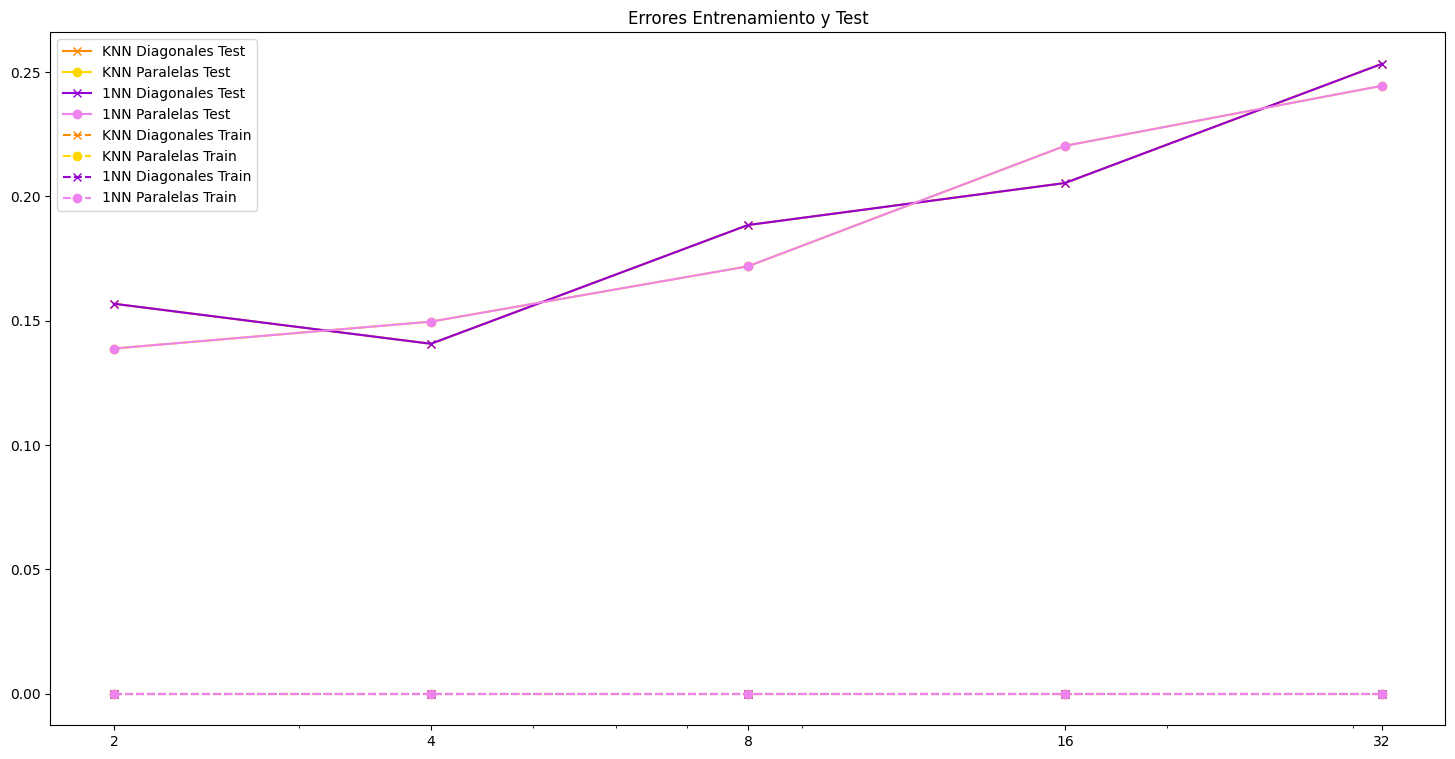

In [ ]:
dfDiagonalesTree = pd.DataFrame(dataDiagonalesTree, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasTree = pd.DataFrame(dataParalelasTree, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesTree = dfDiagonalesTree.groupby('dimension')['errTest'].mean()
promsErrTestParalelasTree = dfParalelasTree.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesTree = dfDiagonalesTree.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasTree = dfParalelasTree.groupby('dimension')['errEntrenamiento'].mean()

dfDiagonalesRed = pd.DataFrame(dataDiagonalesRed, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasRed = pd.DataFrame(dataParalelasRed, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesRed = dfDiagonalesRed.groupby('dimension')['errTest'].mean()
promsErrTestParalelasRed = dfParalelasRed.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesRed = dfDiagonalesRed.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasRed = dfParalelasRed.groupby('dimension')['errEntrenamiento'].mean()

dfDiagonalesBayes = pd.DataFrame(dataDiagonalesBayes, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasBayes = pd.DataFrame(dataParalelasBayes, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesBayes = dfDiagonalesBayes.groupby('dimension')['errTest'].mean()
promsErrTestParalelasBayes = dfParalelasBayes.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesBayes = dfDiagonalesBayes.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasBayes = dfParalelasBayes.groupby('dimension')['errEntrenamiento'].mean()

dfDiagonalesKNN = pd.DataFrame(dataDiagonalesKNN, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelasKNN = pd.DataFrame(dataParalelasKNN, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonalesKNN = dfDiagonalesKNN.groupby('dimension')['errTest'].mean()
promsErrTestParalelasKNN = dfParalelasKNN.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonalesKNN = dfDiagonalesKNN.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelasKNN = dfParalelasKNN.groupby('dimension')['errEntrenamiento'].mean()

dfDiagonales1NN = pd.DataFrame(dataDiagonales1NN, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
dfParalelas1NN = pd.DataFrame(dataParalelas1NN, columns=['dimension', 'conjunto', 'errTest', 'errEntrenamiento'])
promsErrTestDiagonales1NN = dfDiagonales1NN.groupby('dimension')['errTest'].mean()
promsErrTestParalelas1NN = dfParalelas1NN.groupby('dimension')['errTest'].mean()
promsErrEntrenamientoDiagonales1NN = dfDiagonales1NN.groupby('dimension')['errEntrenamiento'].mean()
promsErrEntrenamientoParalelas1NN = dfParalelas1NN.groupby('dimension')['errEntrenamiento'].mean()

plt.figure(figsize=(18, 15))

plt.plot(dimensiones, promsErrTestDiagonalesTree, c='navy', label='Arbol Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasTree, c='cornflowerblue', label='Arbol Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonalesRed, c='darkred', label='Red Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasRed, c='salmon', label='Red Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonalesBayes, c='darkgreen', label='Bayes Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasBayes, c='palegreen', label='Bayes Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonalesKNN, c='darkorange', label='KNN Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasKNN, c='gold', label='KNN Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonales1NN, c='darkviolet', label='1NN Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelas1NN, c='violet', label='1NN Paralelas Test', marker='o', linestyle="-")

plt.plot(dimensiones, promsErrEntrenamientoDiagonalesTree, c='navy', label='Arbol Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasTree, c='cornflowerblue', label='Arbol Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonalesRed, c='darkred', label='Red Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasRed, c='salmon', label='Red Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonalesBayes, c='darkgreen', label='Bayes Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasBayes, c='palegreen', label='Bayes Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonalesKNN, c='darkorange', label='KNN Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasKNN, c='gold', label='KNN Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonales1NN, c='darkviolet', label='1NN Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelas1NN, c='violet', label='1NN Paralelas Train', marker='o', linestyle="--")

plt.legend()
plt.xscale('log')
plt.title('Errores Entrenamiento y Test')
plt.xticks(dimensiones, labels=[str(dimension) for dimension in dimensiones])

plt.show()

plt.figure(figsize=(18, 9))

plt.plot(dimensiones, promsErrTestDiagonalesKNN, c='darkorange', label='KNN Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelasKNN, c='gold', label='KNN Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, promsErrTestDiagonales1NN, c='darkviolet', label='1NN Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, promsErrTestParalelas1NN, c='violet', label='1NN Paralelas Test', marker='o', linestyle="-")

plt.plot(dimensiones, promsErrEntrenamientoDiagonalesKNN, c='darkorange', label='KNN Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelasKNN, c='gold', label='KNN Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoDiagonales1NN, c='darkviolet', label='1NN Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, promsErrEntrenamientoParalelas1NN, c='violet', label='1NN Paralelas Train', marker='o', linestyle="--")

plt.legend()
plt.xscale('log')
plt.title('Errores Entrenamiento y Test')
plt.xticks(dimensiones, labels=[str(dimension) for dimension in dimensiones])

plt.show()

## Ejercicio 3

In [22]:
MAX_VECINOS = 250
dimensiones = [2, 4, 8, 16, 32]
overlap = 0.78
testSamples = 10000
dataParalelas50NNW = []
dataDiagonales50NNW = []
dataParalelasKNNW = []
dataDiagonalesKNNW = []
dataParalelasKNN = []
dataDiagonalesKNN = []
dataParalelas1NN = []
dataDiagonales1NN = []

In [ ]:
for dimension in dimensiones:
    testDiagonales10000 = diagonales(testSamples, dimension, overlap)
    X_test = testDiagonales10000.drop(columns=['class'])
    y_test = testDiagonales10000['class']

    dfDiagonales = diagonales(250, dimension, overlap)
    X = dfDiagonales.drop(columns=['class'])
    y = dfDiagonales['class']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    best_knn, _, _, _ = entrenar_knn_clasificacion(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)
    errTest = error_clasificacion(y_test, best_knn.predict(X_test))
    errEntrenamiento = error_clasificacion(y_train, best_knn.predict(X_train))
    dataParalelasKNN.append([dimension, errTest, errEntrenamiento])

    best_knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')
    best_knn.fit(X, y)
    errTest = error_clasificacion(y_test, best_knn.predict(X_test))
    errEntrenamiento = error_clasificacion(y, best_knn.predict(X))
    dataParalelas1NN.append([dimension, errTest, errEntrenamiento])
        
    best_knn, _, _, _ = entrenar_knn_clasificacion_peso(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)
    errTest = error_clasificacion(y_test, best_knn.predict(X_test))
    errEntrenamiento = error_clasificacion(y_train, best_knn.predict(X_train))
    dataParalelasKNN.append([dimension, errTest, errEntrenamiento])

    best_knn = KNeighborsClassifier(n_neighbors=50, weights='distance')
    best_knn.fit(X, y)
    errTest = error_clasificacion(y_test, best_knn.predict(X_test))
    errEntrenamiento = error_clasificacion(y, best_knn.predict(X))
    dataParalelas1NN.append([dimension, errTest, errEntrenamiento])

In [ ]:
for dimension in dimensiones:
    testParalelas10000 = paralelas(testSamples, dimension, overlap)
    X_test = testParalelas10000.drop(columns=['class'])
    y_test = testParalelas10000['class']

    dfParalelas = paralelas(250, dimension, overlap)
    X = dfParalelas.drop(columns=['class'])
    y = dfParalelas['class']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    best_knn, _, _, _ = entrenar_knn_clasificacion(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)
    errTest = error_clasificacion(y_test, best_knn.predict(X_test))
    errEntrenamiento = error_clasificacion(y_train, best_knn.predict(X_train))
    dataParalelasKNN.append([dimension, errTest, errEntrenamiento])

    best_knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')
    best_knn.fit(X, y)
    errTest = error_clasificacion(y_test, best_knn.predict(X_test))
    errEntrenamiento = error_clasificacion(y, best_knn.predict(X))
    dataParalelas1NN.append([dimension, errTest, errEntrenamiento])
        
    best_knn, _, _, _ = entrenar_knn_clasificacion_peso(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)
    errTest = error_clasificacion(y_test, best_knn.predict(X_test))
    errEntrenamiento = error_clasificacion(y_train, best_knn.predict(X_train))
    dataParalelasKNN.append([dimension, errTest, errEntrenamiento])

    best_knn = KNeighborsClassifier(n_neighbors=50, weights='distance')
    best_knn.fit(X, y)
    errTest = error_clasificacion(y_test, best_knn.predict(X_test))
    errEntrenamiento = error_clasificacion(y, best_knn.predict(X))
    dataParalelas1NN.append([dimension, errTest, errEntrenamiento])

In [ ]:
dfDiagonalesKNN = pd.DataFrame(dataDiagonalesKNN, columns=['dimension', 'errTest', 'errEntrenamiento'])
dfParalelasKNN = pd.DataFrame(dataParalelasKNN, columns=['dimension', 'errTest', 'errEntrenamiento'])

dfDiagonales1NN = pd.DataFrame(dataDiagonales1NN, columns=['dimension', 'errTest', 'errEntrenamiento'])
dfParalelas1NN = pd.DataFrame(dataParalelas1NN, columns=['dimension', 'errTest', 'errEntrenamiento'])

dfDiagonalesKNNW = pd.DataFrame(dataDiagonalesKNNW, columns=['dimension', 'errTest', 'errEntrenamiento'])
dfParalelasKNNW = pd.DataFrame(dataParalelasKNNW, columns=['dimension', 'errTest', 'errEntrenamiento'])

dfDiagonales50NNW = pd.DataFrame(dataDiagonales50NNW, columns=['dimension', 'errTest', 'errEntrenamiento'])
dfParalelas50NNW = pd.DataFrame(dataParalelas50NNW, columns=['dimension', 'errTest', 'errEntrenamiento'])

plt.figure(figsize=(18, 15))

plt.plot(dimensiones, dfDiagonalesKNN['errTest'], c='darkorange', label='KNN Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, dfParalelasKNN['errTest'], c='gold', label='KNN Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, dfDiagonales1NN['errTest'], c='darkviolet', label='1NN Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, dfParalelas1NN['errTest'], c='violet', label='1NN Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, dfDiagonalesKNNW['errTest'], c='navy', label='KNNW Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, dfParalelasKNNW['errTest'], c='cornflowerblue', label='KNNW Paralelas Test', marker='o', linestyle="-")
plt.plot(dimensiones, dfDiagonales50NNW['errTest'], c='darkgreen', label='50NNW Diagonales Test', marker='x', linestyle="-")
plt.plot(dimensiones, dfParalelas50NNW['errTest'], c='palegreen', label='50NNW Paralelas Test', marker='o', linestyle="-")

plt.plot(dimensiones, dfDiagonalesKNN['errEntrenamiento'], c='darkorange', label='KNN Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, dfParalelasKNN['errEntrenamiento'], c='gold', label='KNN Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, dfDiagonales1NN['errEntrenamiento'], c='darkviolet', label='1NN Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, dfParalelas1NN['errEntrenamiento'], c='violet', label='1NN Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, dfDiagonalesKNNW['errEntrenamiento'], c='navy', label='KNNW Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, dfParalelasKNNW['errEntrenamiento'], c='cornflowerblue', label='KNNW Paralelas Train', marker='o', linestyle="--")
plt.plot(dimensiones, dfDiagonales50NNW['errEntrenamiento'], c='darkgreen', label='50NNW Diagonales Train', marker='x', linestyle="--")
plt.plot(dimensiones, dfParalelas50NNW['errEntrenamiento'], c='palegreen', label='50NNW Paralelas Train', marker='o', linestyle="--")

plt.legend()
plt.xscale('log')
plt.title('Errores Entrenamiento y Test')
plt.xticks(dimensiones, labels=[str(dimension) for dimension in dimensiones])

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
testParalelas10000 = paralelas(testSamples, 32, overlap)
X_test = testParalelas10000.drop(columns=['class'])
y_test = testParalelas10000['class']

dfParalelas = paralelas(250, 32, overlap)
X = dfParalelas.drop(columns=['class'])
y = dfParalelas['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

bestknn, error_train, error_val, error_test = entrenar_knn_clasificacion(MAX_VECINOS, X_train, y_train, X_val, y_val, X_test, y_test)
plot_errors_knn(axs, error_train, error_val, error_test, MAX_VECINOS, 'Errores KNN Paralelas')
plt.show()